In [3]:
import spacy
import openai
import json
import os
from dotenv import load_dotenv
from tenacity import retry, stop_after_attempt, wait_random_exponential
from random import sample, seed
import re

In [97]:
nlp = spacy.load("en_core_web_sm")

In [5]:
custom_ner = nlp.add_pipe("ner", name="custom_ner")
custom_ner.add_label("TECHNOLOGY")

1

In [6]:
load_dotenv()

True

## Before putting anything in to the openai api
Set up a binary classifier to identify if a given paragraph has any relevance to the task.  I.e. if it contains any technologies/skills that I might want to take out.  
### First step is to grab a bunch of paragraphs from job descriptions, label a few hundred as relevant or not.

In [7]:
job_desc_list = []
with open(fr"data/raw_data-09-09-23.json") as f:
    data = json.load(f)

In [8]:
len(job_desc_list)

0

In [9]:
for key in list(data.keys()):
    if key.startswith("metadata"):
        continue
    else:
        job_desc_list.append(data[key]['desc'])

In [26]:
len(job_desc_list)/2

136.0

In [12]:
#not many jobs in total here, randomly sample half of them to label. set seed for reproducability
seed(10) 
jobs_to_label = sample(job_desc_list, int(len(job_desc_list)/2))

In [26]:
# print(jobs_to_label[85])

In [145]:
def split_text_to_nths(text, nths):
    "Splits the text roughly into 'n'ths e.g. if n=10, to 10ths"
    n_nlines = text.count('\n')
    num_to_split = n_nlines // nths #number of newlines to split at to get roughly 10ths in each text output
    split_text = re.findall("\n".join(["[^\n]+"]*num_to_split), text)
    return [(x.strip(), " ") for x in split_text]  # leave a space after each one for a 0/1 label for binary classifier

In [144]:
job_desc_list[82]

'Overview: \n  \n   Amyx is seeking a Zero Trust Security, Orchestration, Automation and Response (SOAR) Cyber Security Engineer (CSE) to support our TRANSCOM J6 SISO contract located at Scott AFB, IL\n  \n \n   In this role, the SOAR CSE will bring the background and experience collecting and analyzing data, and developing/implementing automated solutions that trigger worflows, alerts and other actions based on the results of data analysis. Data collected and analyzed will be retrieved from tools, applications and devices that comprise on-premises and cloud-based network environments. The ideal candidate will work collaboratively with our team and our customer to assess existing data collection and automation capabilities, examine other opportunities for automation, and increase the value of collected such that it can be used to further automation capabilities and provide additional insight into the overall security posture of network environments and applications running in those env

In [61]:
all_split_texts = []
for text in jobs_to_label:
    all_split_texts.append(split_text_to_nths(text, 5))

In [62]:
from itertools import chain

In [64]:
# turns list of lists into just one big list.
# print(list(chain.from_iterable(all_split_texts)))
# label 136 job descs

In [71]:
with open(fr"data/classifier_data/labelled_01.txt", encoding='utf8') as f:
    data = f.read()
    

In [85]:
labeled_data = [(textstr, int(label.strip())) for textstr, label in list(eval(data))]

In [86]:
labeled_data

[('Collaborate closely with cross-functional teams including data scientists, product managers, and software developers to understand requirements and objectives for building a benchmark chat application. \n Leverage your in-depth knowledge of the Google Cloud Platform and associated tools to design, develop, and deploy scalable and reliable solutions. \n Utilize Google Gen AI App Builder to create a chat application that showcases the capabilities of AI-powered conversation models. \n Work with existing data sets to ensure consistent and relevant input for the chat application, ensuring optimal performance and benchmarking accuracy.',
  1),
 ('Qualifications and Skills: \n \n Data engineer or software engineer who must be hands on with GCP platform and tools, and understand Gen AI technologies (Google Gen AI App Builder). \n Use Google Gen AI App Builder to build benchmark chat based on same data sets \n Deep understanding of General Artificial Intelligence (Gen AI) technologies, part

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [104]:
X_vals = [textstr for textstr, label in list(eval(data))] #212 labelled paragraphs rn
y_vals = [int(label.strip()) for textstr, label in list(eval(data))]

In [114]:
print(f"About {round(y_vals.count(1)/len(y_vals),2)*100}% of our labeled data contain tech names, leaving about {round(y_vals.count(0)/len(y_vals),2)*100}% which do not.")

About 38.0% of our labeled data contain tech names, leaving about 62.0% which do not.


In [127]:
# Tokenize/preprocess text using spacy
processed = [" ".join([token.lemma_ for token in nlp(paragraph)]) for paragraph in X_vals]
X_train, X_test, y_train, y_test = train_test_split(processed, y_vals, test_size=0.2, random_state=10)

In [128]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000) #Small # features, shouldn't need to set max_features here I don't think?
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

LogisticRegression()

In [129]:
acc = clf.score(X_test_tfidf, y_test)
print(acc)

0.8372093023255814


Check a confusion matrix to see results

In [141]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
y_pred = clf.predict(X_test_tfidf)

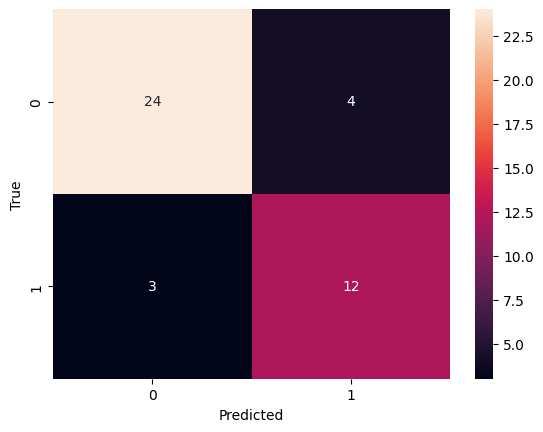

In [143]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

So we have a roughly 84% accurate binary classifier for if a 'paragraph' contains tech words or not.  The confusion matrix seems to show that it isn't too biased one way or the other for incorrect labels, though our labelled data is biased overall towards non-tech paragraphs.

Assume that this classifier is good enough.  We now want to feed in every job desc we have.

In [214]:
def check_for_techs(text, vectorizer, clf, n=5):
    original_text = text
    
    # Don't use split function as we don't want the output I use to label them manually.
    splits = text.count("\n")//n
    split_text = re.findall("\n".join(["[^\n]+"]*splits), original_text)
    processed = [" ".join([token.lemma_ for token in nlp(para)]) for para in split_text]
    
    transformed = vectorizer.transform(processed)
    pred_vals = clf.predict(transformed)
    
    zipped_paras = list(zip(split_text, pred_vals))
    # return(zipped_paras)
    return " ".join([text for (text, label) in zipped_paras if label == 1])
    
#input the full job desc, split it into the 5ths, check each 5th if it contains tech with our classifier, if it does then we keep the original and join with others that do
#if it doesn't, we get rid of that paragraph.
# want to keep original text not just vectorized.
# will do something like:
# for text in job_desc_list:
    # with_techs_text = check-for_techs(text)
    # get_techs_from_openai(with_techs_text)

In [217]:
shortened_jds = []
for jd in job_desc_list:
    shortened_jds.append(check_for_techs(jd, tfidf_vectorizer, clf, 5))

In [219]:
shortened_jds[0]

" \n  Possesses either an undergraduate or Master's degree in a quantitative field (e.g. mathematics, finance, statistics, or similar) or confirmed experience within data science and analytics \n  3+ years of work experience involving quantitative data analysis and complex problem solving \n  Excellent communication skills with the ability to distill complex issues and detailed analysis into simple, structured frameworks with concrete action plans \n  Experience building statistical models to yield insights from complex user journeys. Experience in maintaining and developing production-grade models is a must. \n  Strong proficiency in Python and/or another programming language; experience using SQL, Tableau, Excel and Airflow. \n  Experience in experimentation methodologies, causal inferences and pricing \n  Strong product sense \n "

In [221]:
import pickle

In [222]:
# save our model and vectorizer
# with open("job_desc_classifier_v1.0.pkl", "wb") as model_file:
#     pickle.dump(clf, model_file)
# with open("job_desc_tfidf_vectorizerv1.0.pkl", "wb") as vect_file:
#     pickle.dump(tfidf_vectorizer, vect_file)

In [ ]:
# To re-use the saved model:
with open("job_desc_classifier_v1.0.pkl", "rb") as model_file:
    clf = pickle.load(model_file)
with open("job_desc_tfidf_vectorizerv1.0.pkl", "rb") as vect_file:
    tfidf_vectorizer = pickle.load(vect_file)

In [20]:
api_key = os.getenv("openai_api_key")
example_text_1 = os.getenv("example_text_1")
example_text_2 = os.getenv("example_text_2")

In [12]:
# Originally from getTechs.py
def get_techs(text):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role":"system", "content":"You identify specific technology names from job descriptions.  Respond only with a list of the names of the specific technologies."},
            {"role":"user", "content":f"Identify the specific technologies in the following text and respond with them in a list: {example_text_1}"},
            {"role":"assistant", "content":"llama 2, python, pytorch"},
            {"role":"user", "content":f"Identify the specific technologies in the following text: {example_text_2}"},
            {"role":"assistant", "content":"python, spark, sql, snowflake, tableau, aws, azure, power bi"},
            {"role":"user", "content":f"Identify the specific technologies in the following text: {text}"}
        ]
    )
    return response

In [9]:
def dict_to_json(dict, filepath):
    with open(filepath, "w") as out:
        json.dump(dict, out)

In [ ]:
# Originally from getTechs.py
# Modified to remove counter, use to just get my spacy training data.

### Does the original json file need to be closed?  I'm unsure how it works when renaming then dumping.  The new file is definitely closed as it's in the with open() command
### Original file may not be? Think about and fix if necessary
def print_attempt_number(retry_state):
    print(f"Retrying: {retry_state.attempt_number}...")
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6), after=print_attempt_number)
def get_tech_list(filepath):
    f = open(filepath)
    data = json.load(f)
    for key in list(data.keys()):
        job_desc = data[key]['desc']
        response = get_techs(job_desc) # keep whole object in case I want metadata from it later
        response_list = [x.lower() for x in response["choices"][0]["message"]["content"].split(", ")]
        data[key]['techs'] = response_list 
    # dict_to_json originally from jobSearch.py, use to indicate which files have already been parsed
    # Right now saves file separately, keeping original.  When done with testing will want it to overwrite.  Then it won't matter if the original is saved or not as we'll delete it anyways.
    dict_to_json(data, f"p-{filepath}")  

In [ ]:
# for filename in os.listdir("data"):
#     if filename.startswith("p-"): #already been parsed
#         continue
#     else:
#         filepath = fr"data/{filename}"
#         get_tech_list(filename) # remember this saves the files separately, keeping the original for now.
        

Above will put the openai decided techs into a list in data[job_id]['techs'].  Can now use data itself for training spacy

In [28]:
# Test with only the first json now
# Hit error with rate limits on openai api
# https://platform.openai.com/docs/guides/rate-limits/error-mitigation
get_tech_list(fr"data/07-09-23-q-data+science-data+analysis-data+engineer-mle-machine+learning-mlops-l-remote.json")

RetryError: RetryError[<Future at 0x1b20bea8af0 state=finished raised RateLimitError>]